## Classification
### Stroke Prediction Dataset

#### Attribute Information:
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [2]:
import pandas as pd
import numpy as np

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import toad
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# import dalex as dx

In [10]:
df = pd.read_csv(r'C:\Studia\Master\ML2\Projects\data\c1.csv')
# df['ever_married'] = pd.get_dummies(df['ever_married'], drop_first=True).astype(int)
# df_dummies_ss = pd.get_dummies(df['smoking_status'], drop_first=True, prefix='smoking_status').astype(int)
# df_dummies_rt = pd.get_dummies(df['Residence_type'], drop_first=True, prefix = 'Residence_type').astype(int)
# df_dummies_wt = pd.get_dummies(df['work_type'], drop_first=True, prefix = 'work_type').astype(int)
# df_dummies_g = pd.get_dummies(df['gender'], drop_first=True, prefix = 'gender').astype(int)

# df = pd.concat([df.drop(columns=['smoking_status', 'Residence_type', 'work_type', 'gender', 'id']), df_dummies_ss, df_dummies_rt, df_dummies_wt, df_dummies_g], axis = 1)

In [11]:
df.columns

Index(['id', 'age', 'avg_glucose_level', 'bmi', 'ever_married', 'feat01',
       'feat02', 'feat03', 'feat04', 'feat05', 'feat06', 'feat07', 'feat08',
       'feat09', 'feat10', 'gender', 'heart_disease', 'hypertension',
       'Residence_type', 'smoking_status', 'stroke', 'work_type'],
      dtype='object')

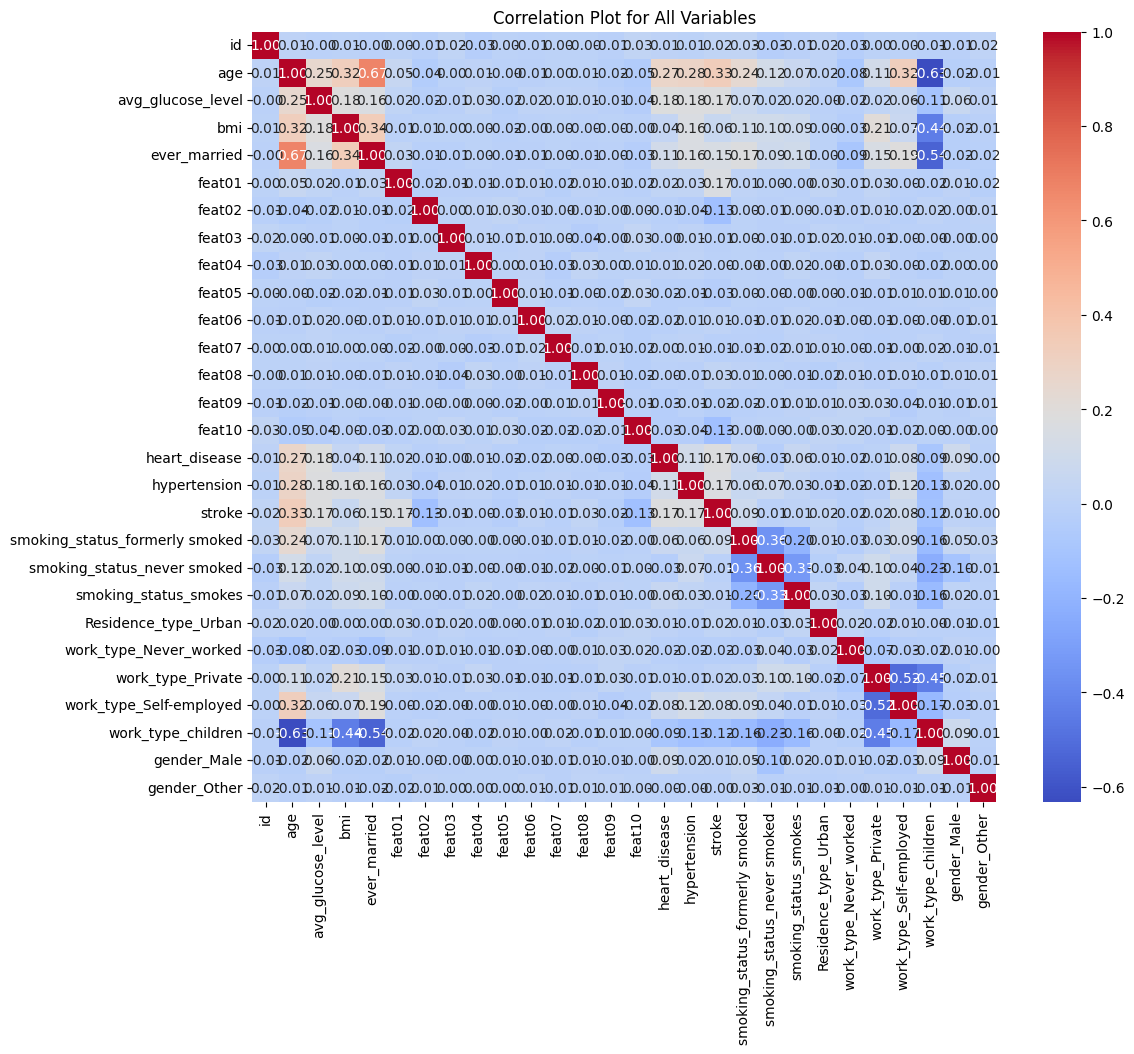

In [32]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot for All Variables')
plt.show()


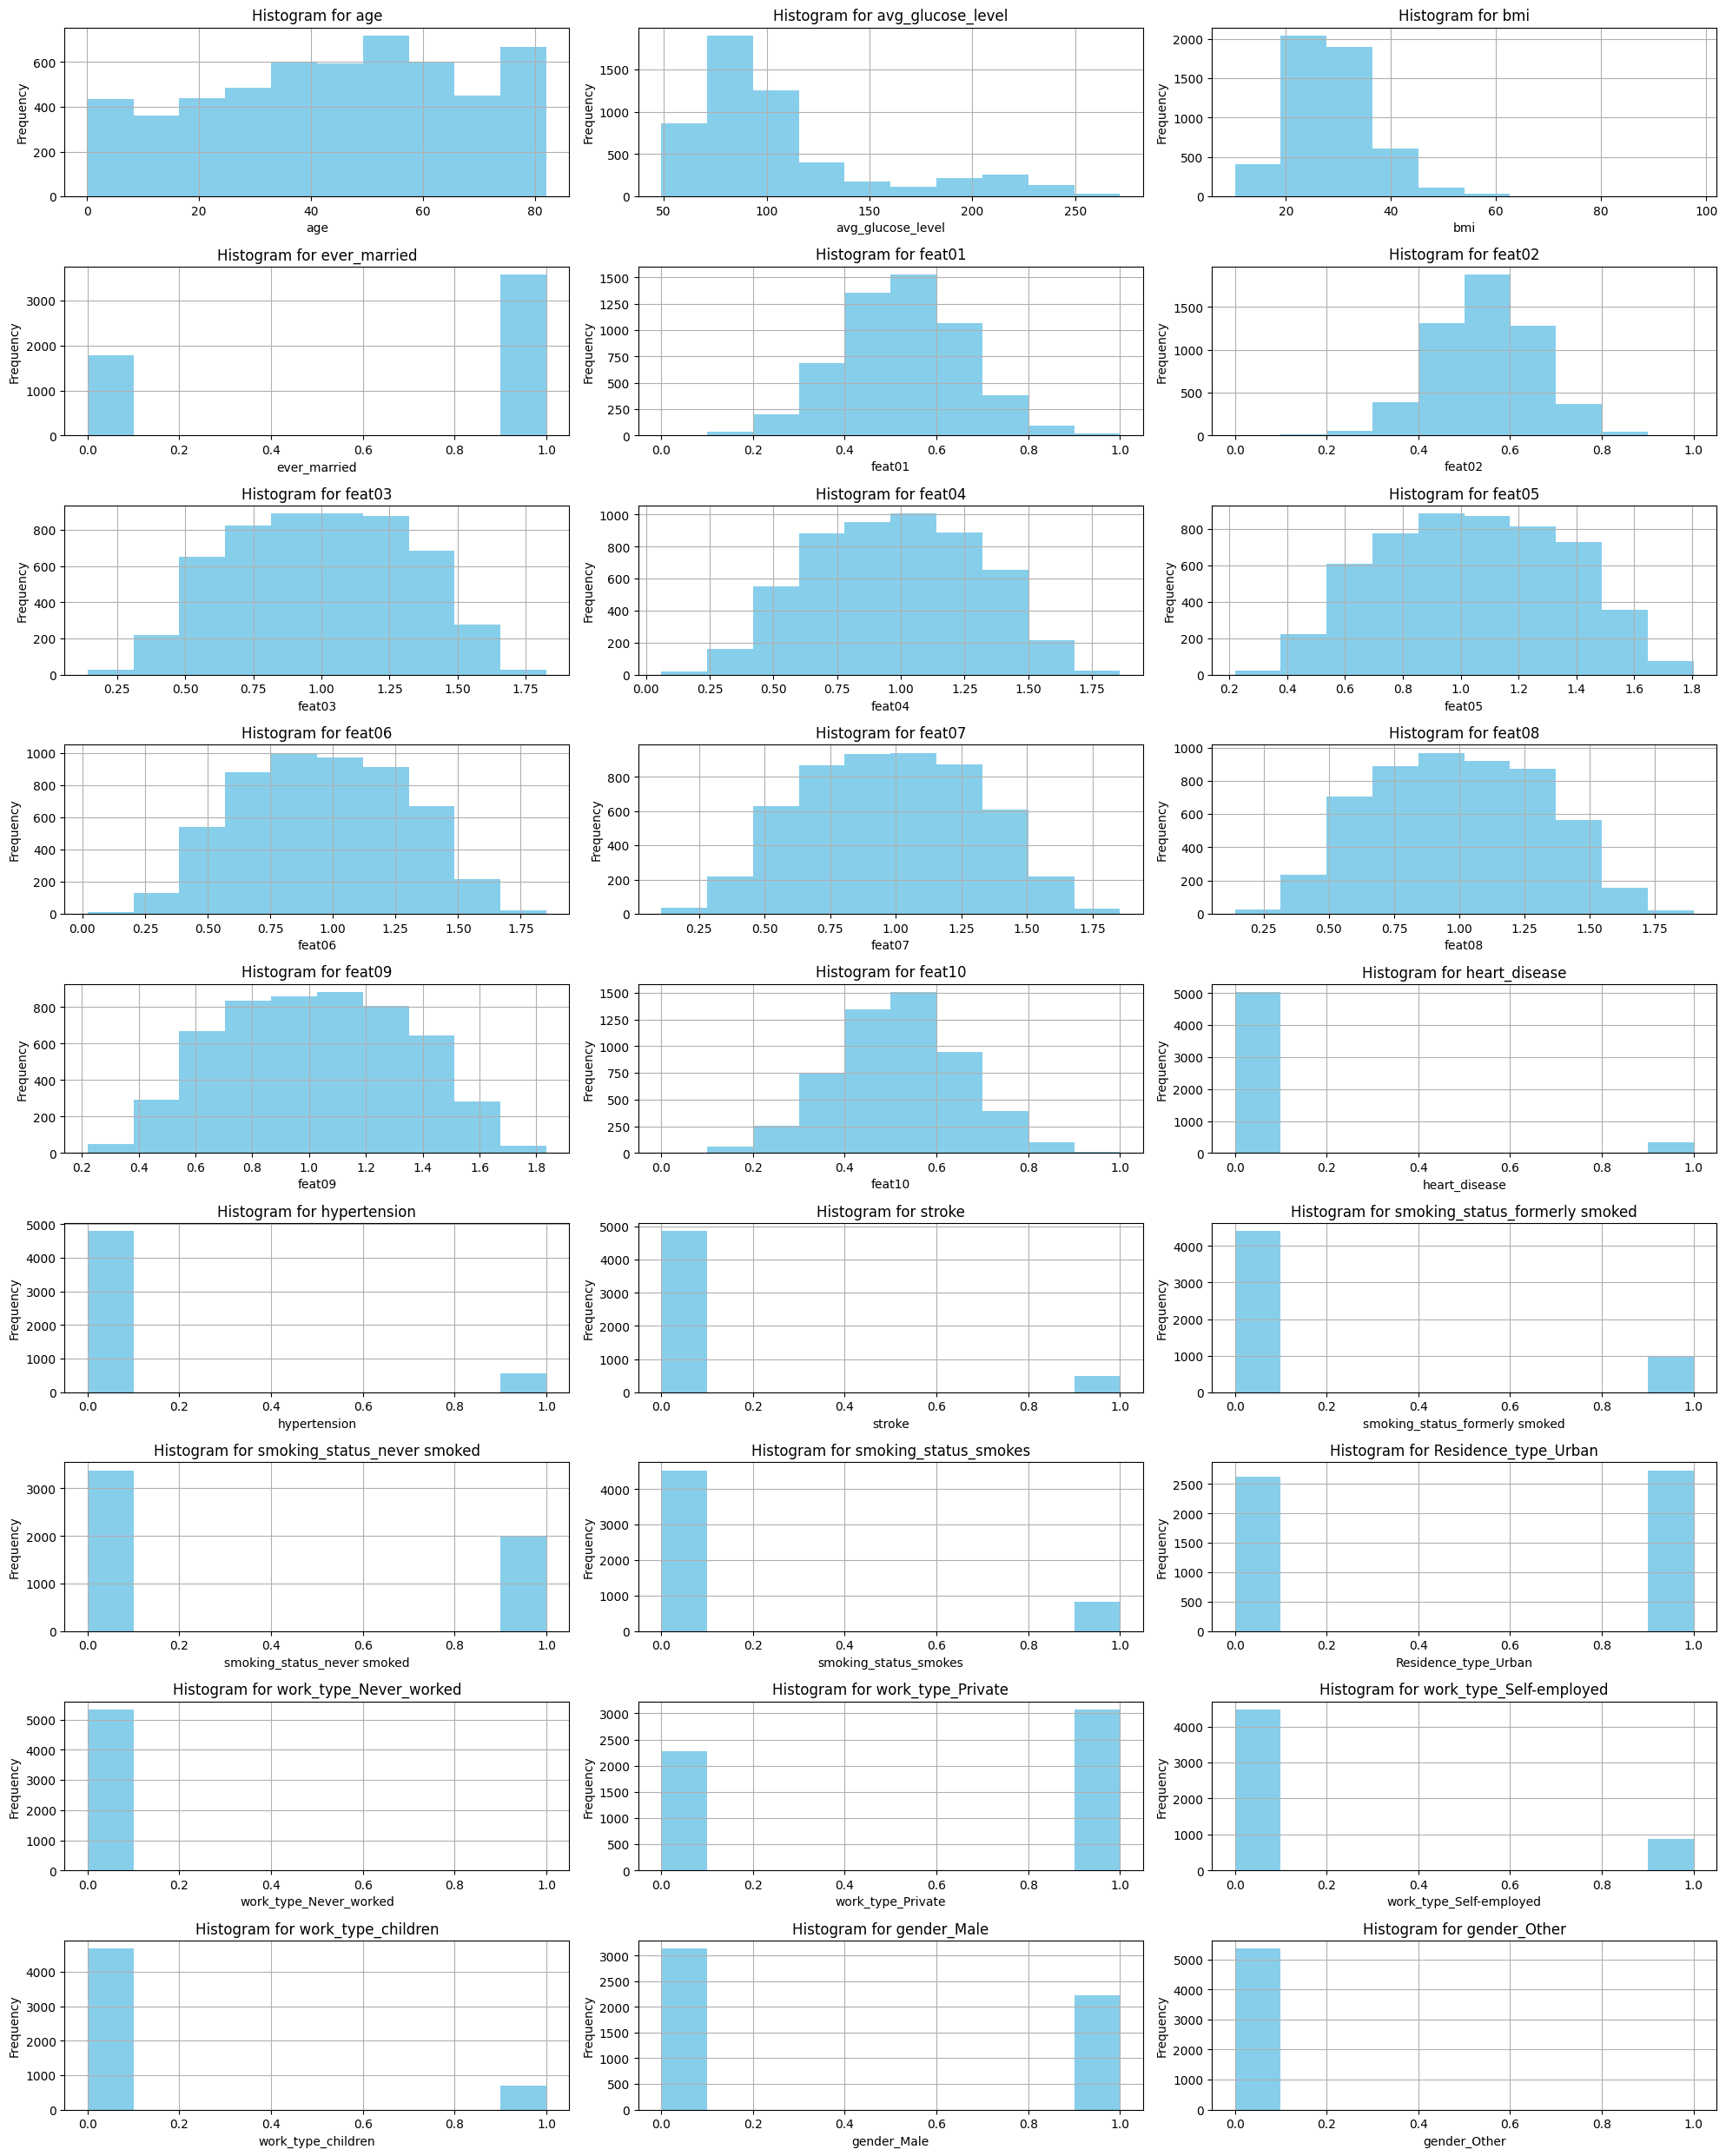

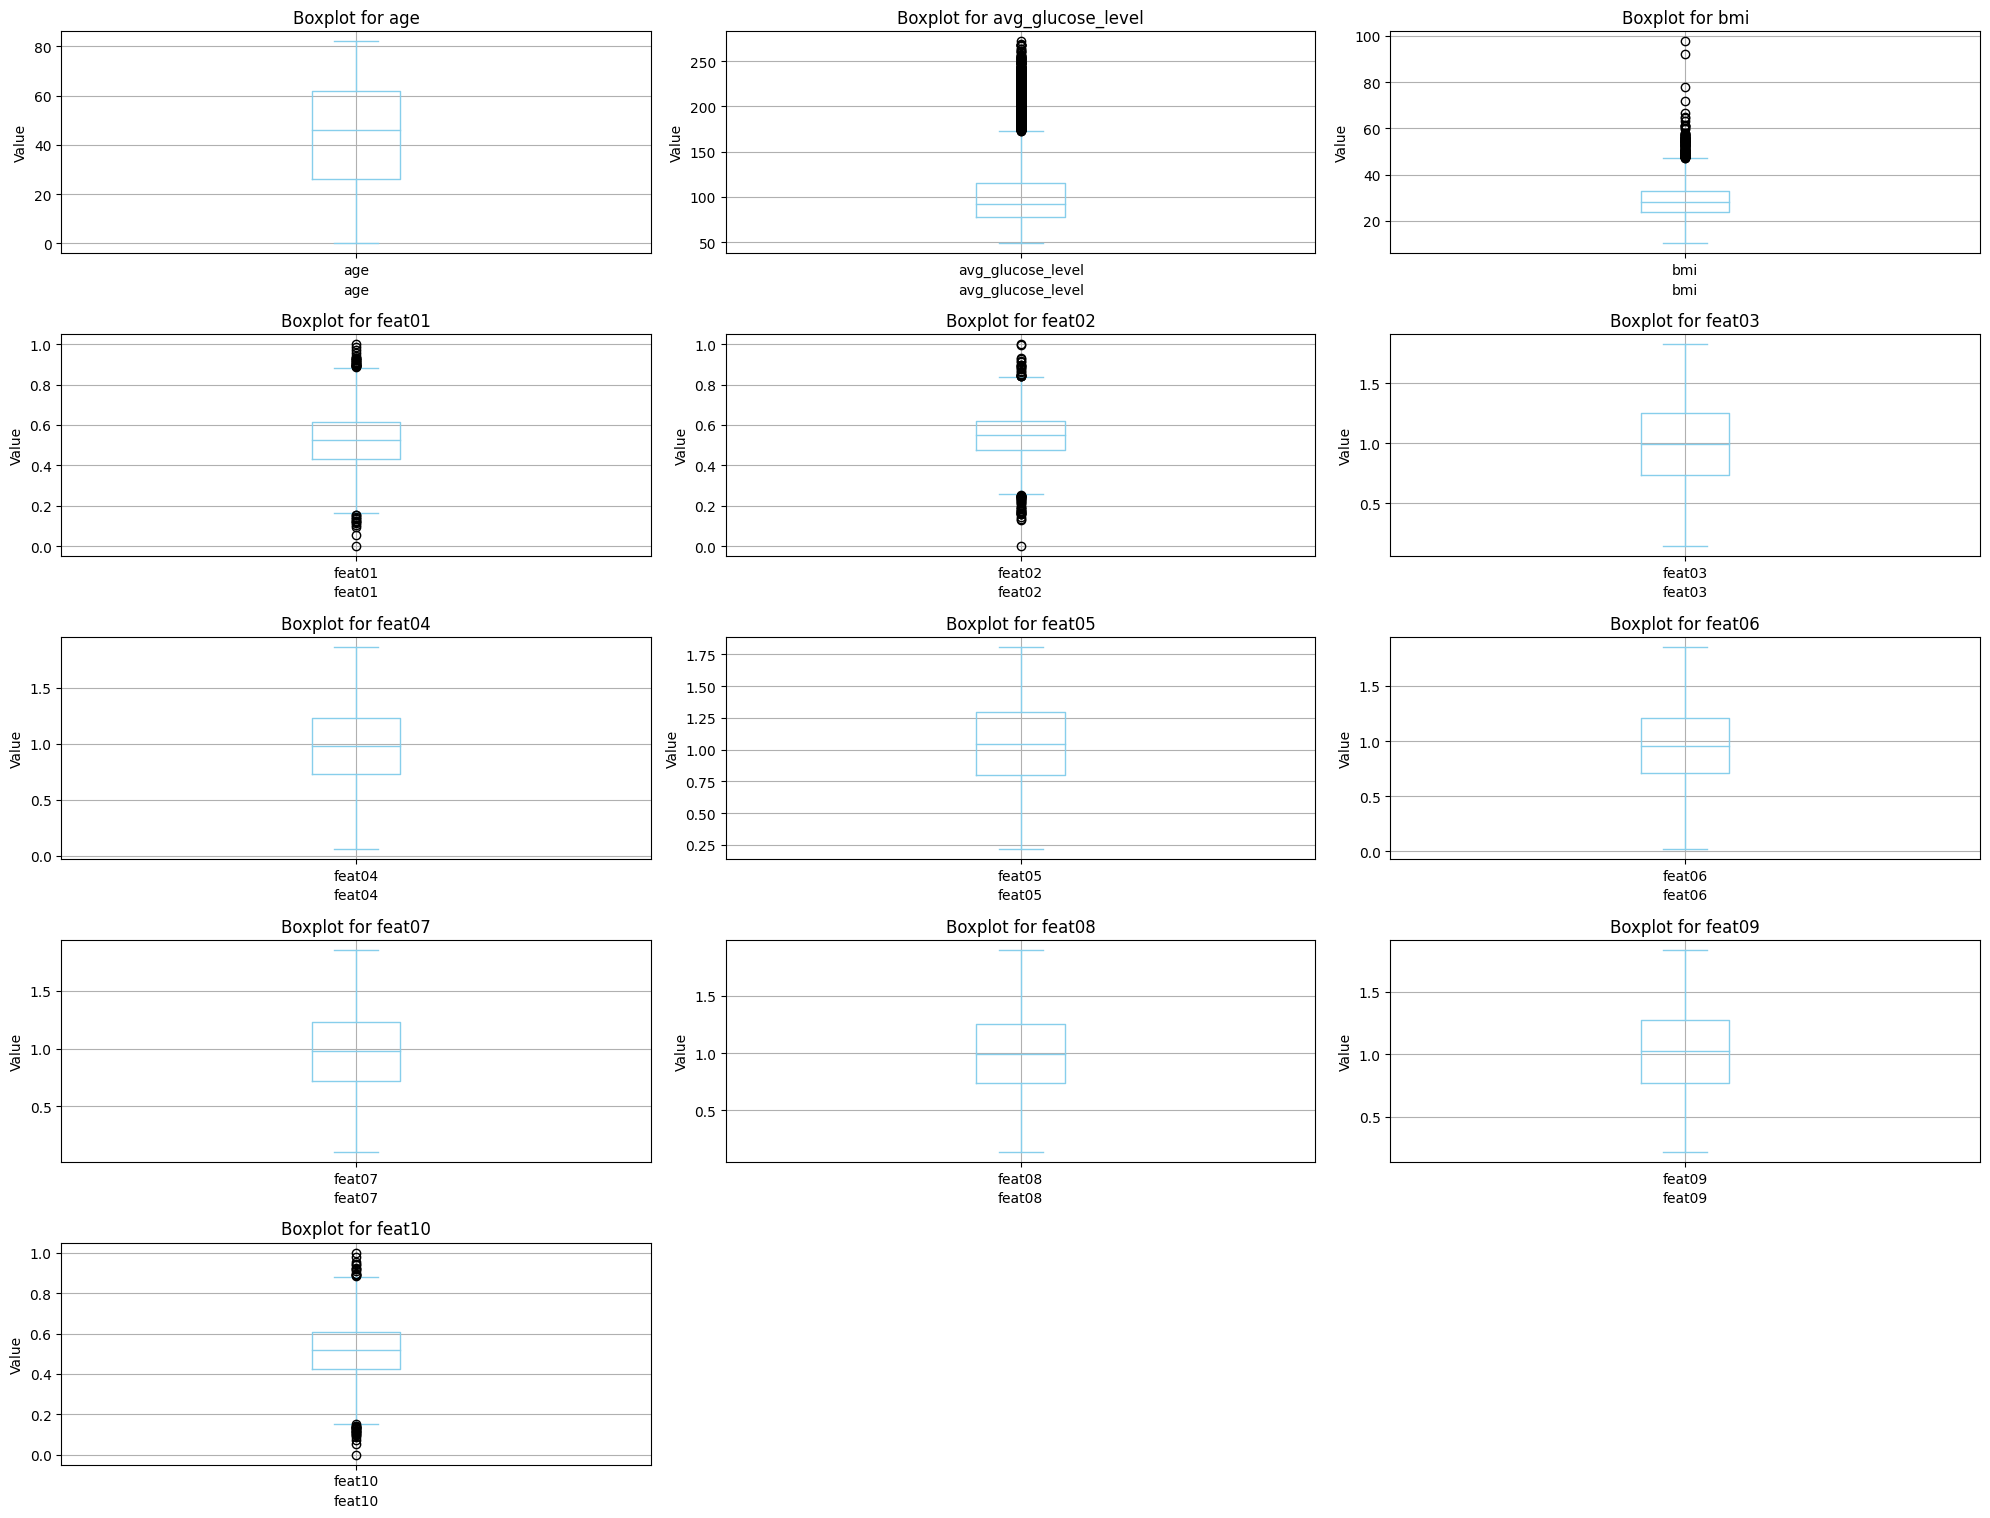

In [3]:
df.head()

,id,age,avg_glucose_level,bmi,ever_married,feat01,feat02,feat03,feat04,feat05,...,feat08,feat09,feat10,gender,heart_disease,hypertension,Residence_type,smoking_status,stroke,work_type
0,1,43.0,92.71,30.5,Yes,0.621595,0.663593,1.070288,1.274483,1.390726,...,1.174715,1.130743,0.415774,Male,0,0,Urban,formerly smoked,0,Private
1,2,59.0,93.90,42.2,Yes,0.285822,0.405060,1.272207,0.950317,1.560437,...,0.909982,0.584846,0.595532,Male,0,0,Rural,never smoked,0,Private
2,3,25.0,92.14,36.2,Yes,0.695876,0.496342,1.466843,1.026262,0.513870,...,1.525299,0.822255,0.127624,Male,0,0,Rural,Unknown,0,Private
3,4,74.0,205.84,54.6,Yes,0.718109,0.408475,0.643750,0.895183,0.965370,...,1.400300,1.242594,0.329102,Female,0,1,Urban,never smoked,0,Self-employed
4,5,34.0,79.80,37.4,Yes,0.472225,0.463821,1.161195,1.308394,0.802539,...,1.512413,1.310592,0.336690,Female,0,0,Urban,smokes,0,Private


### Data split

In [13]:
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

lbl = preprocessing.LabelEncoder() 
col_invalid = ['ever_married', 'gender', 'Residence_type', 'smoking_status', 'work_type']
for col in col_invalid:
    X[col] = lbl.fit_transform(X[col].astype(str))



seed = 15
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

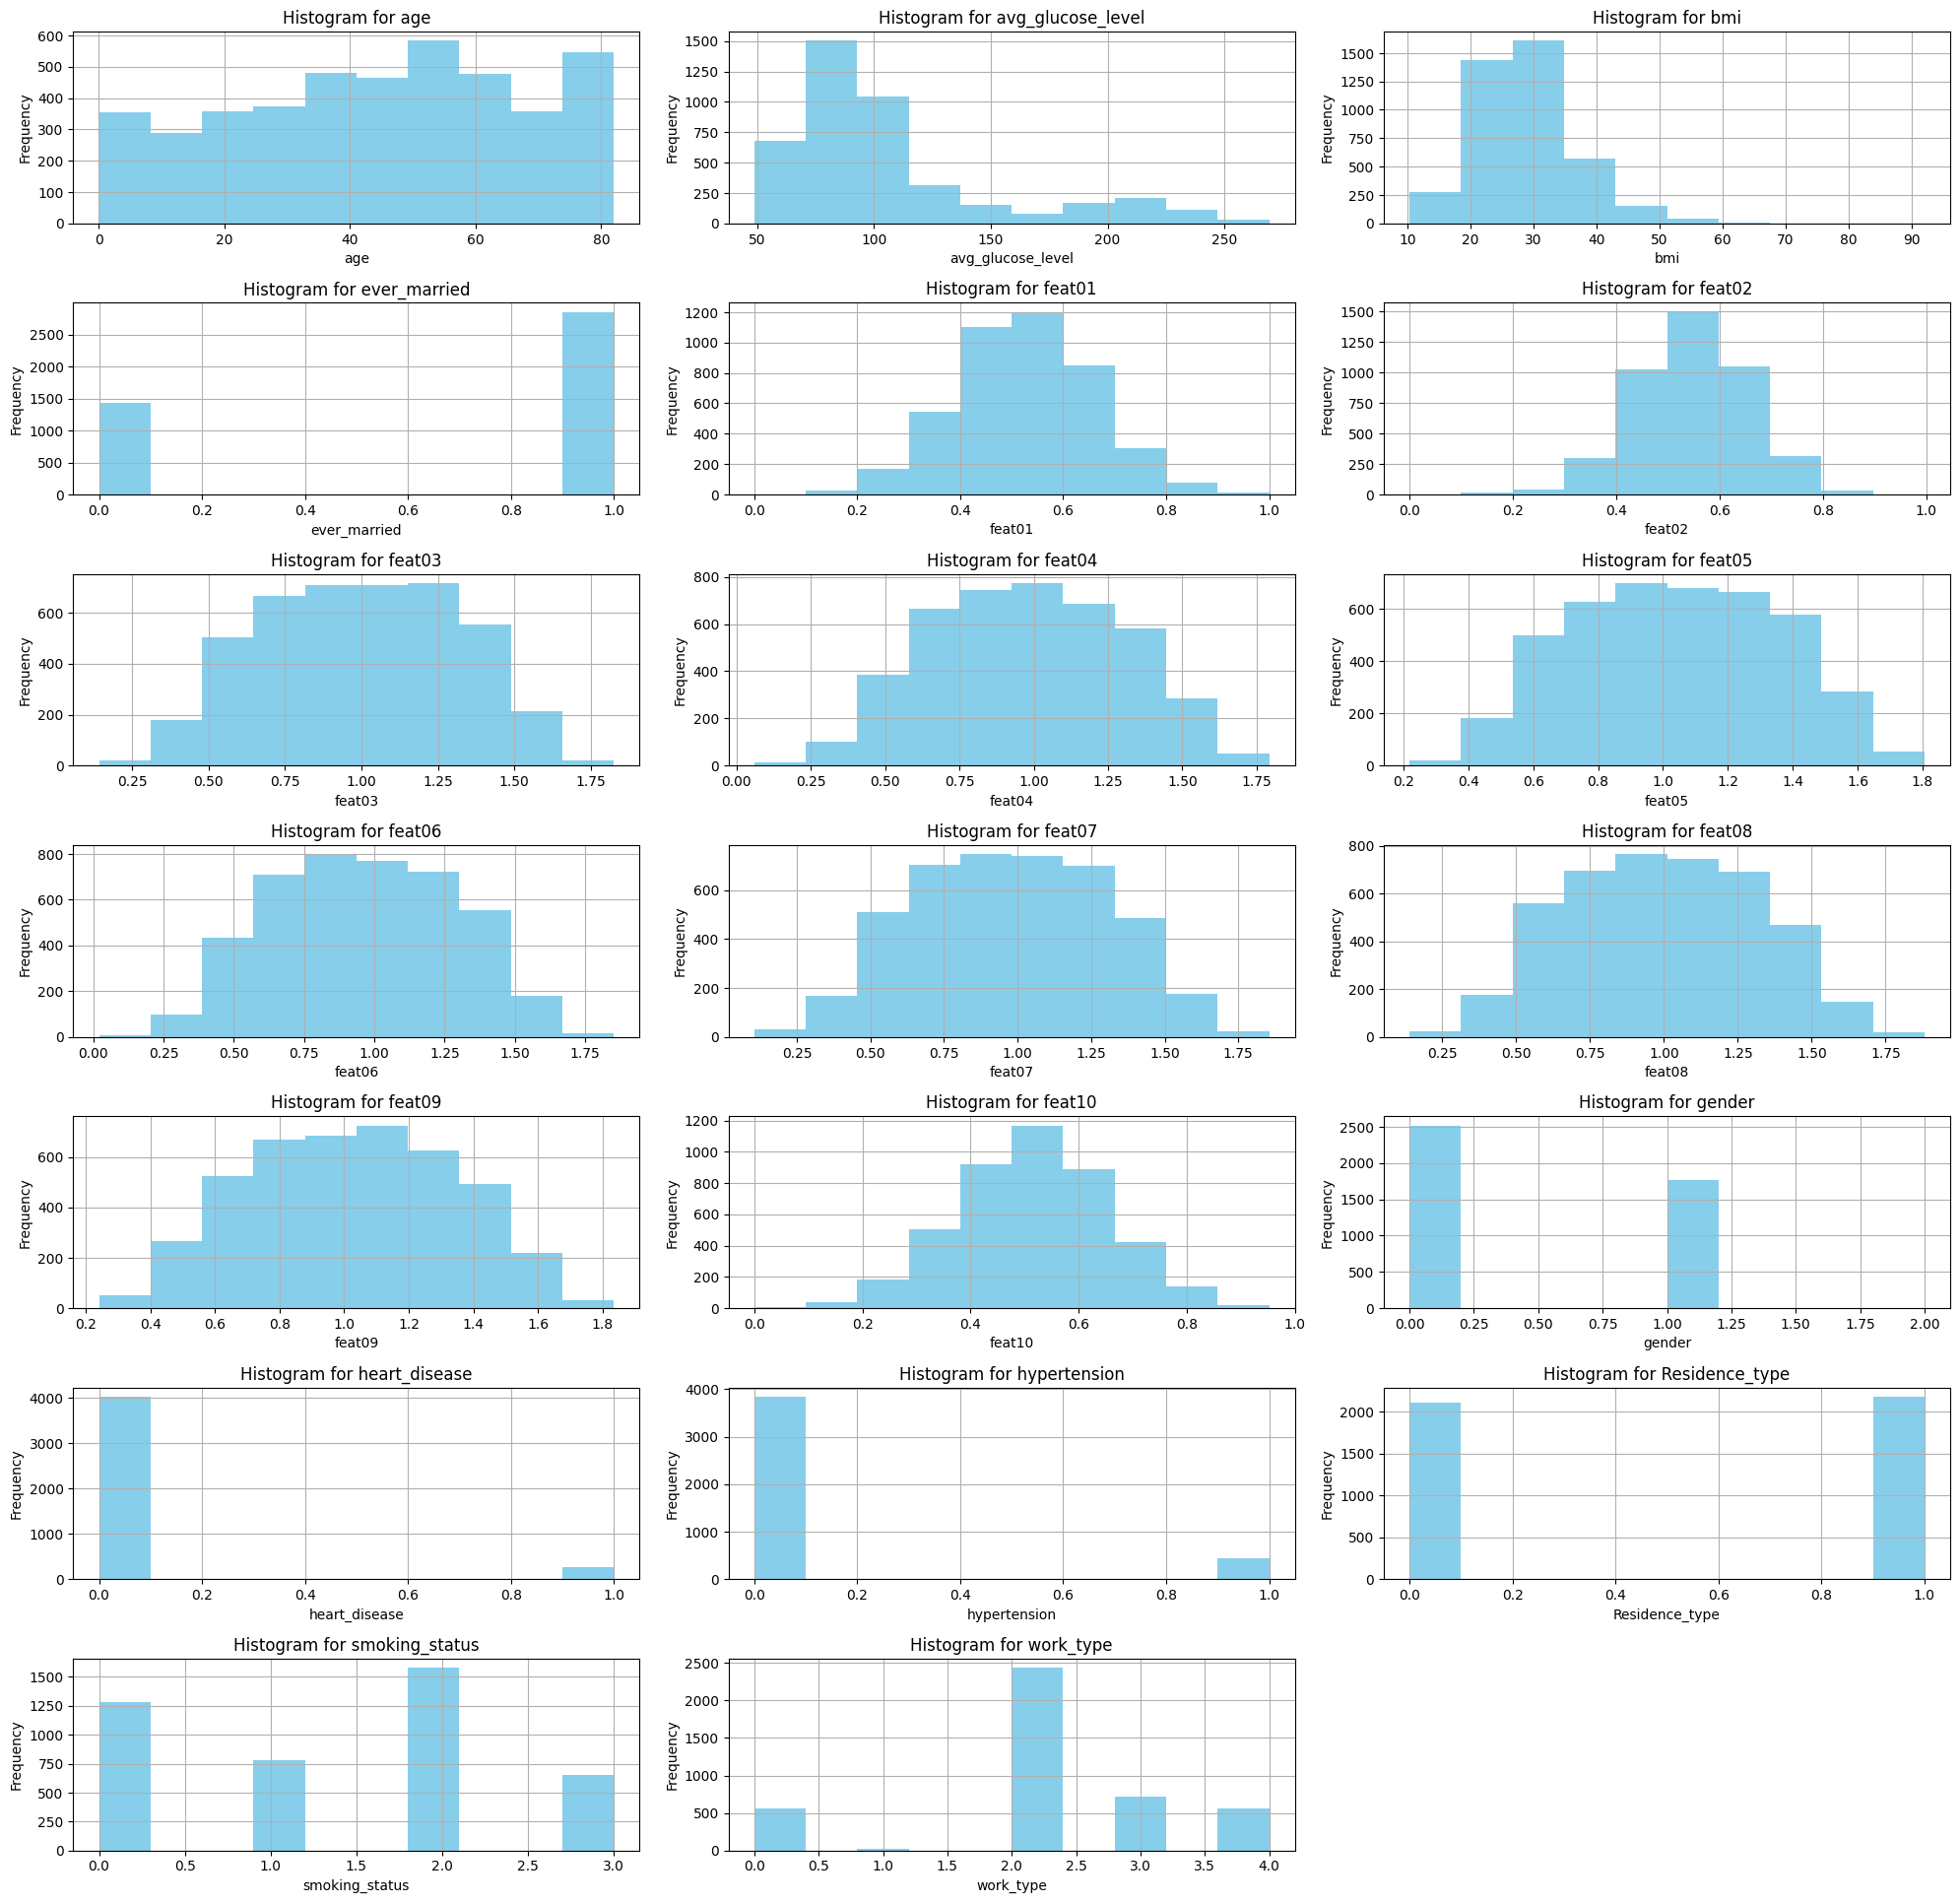

In [34]:
# Set up subplots with 2 columns and 7 rows
num_rows = 11
num_columns = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 30))

# Flatten the 2D array of subplots into a 1D array for easy indexing
axes = axes.flatten()

# Plot histograms for each variable on separate subplots
for i, variable in enumerate(X_train.columns):
    X_train[variable].hist(ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram for {variable}')
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots if there are fewer variables than total subplots
for j in range(len(X_train.columns), num_rows * num_columns):
    fig.delaxes(axes[j])

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
variables_to_plot = [col for col in X_train.columns if X_train[col].nunique() > 2]

# Set up subplots with 2 columns and 7 rows
num_rows = 10
num_columns = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 30))

# Flatten the 2D array of subplots into a 1D array for easy indexing
axes = axes.flatten()

# Plot boxplots for each variable on separate subplots
for i, variable in enumerate(variables_to_plot):
    X_train.boxplot(column=variable, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot for {variable}')
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Value')

# Remove any empty subplots if there are fewer variables than total subplots
for j in range(len(variables_to_plot), num_rows * num_columns):
    fig.delaxes(axes[j])

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
numerical_features = ['age', 'avg_glucose_level', 'bmi', 'feat01', 'feat02',
       'feat03', 'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat09',
       'feat10', 'heart_disease', 'hypertension', 'ever_married']
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_features = [ 'Residence_type', 'smoking_status', 'work_type']
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

classifier = MLPClassifier(random_state=0)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])

clf.fit(X_train, y_train)


# # model.feature_importances_
# sorted_idx = clf.feature_importances_.argsort()
# plt.figure(figsize=(10,15))
# plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.show()


c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi', 'feat01', 'feat02',
                                                   'feat03', 'feat04', 'feat05',
                                                   'feat06', 'feat07', 'feat08',
                                                   'feat09', 'feat10',
                                                   'heart_disease',
                                                   'hypertension',
                                                   'ever_married']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Residence_type',
                                                   'smoking_status',
                                                   'work_type'])])),
                ('classifier', MLPClassifier(random_state=0))])

Accuracy: 91.32%


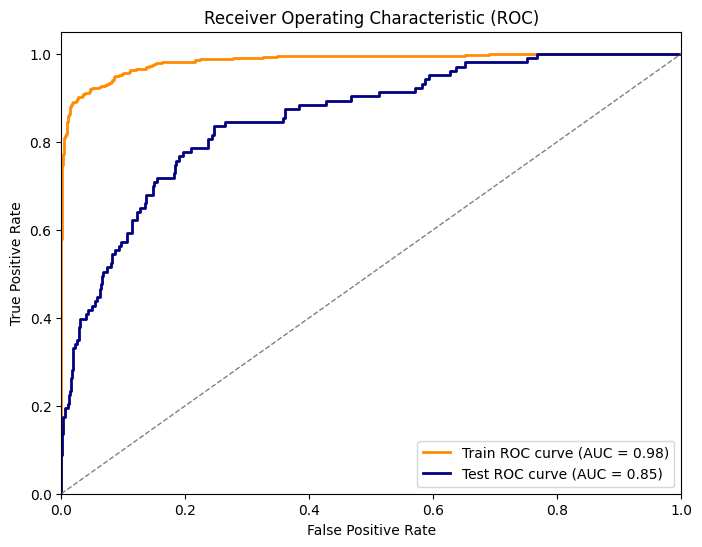

In [51]:
y_pred = clf.predict(X_test)


predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = clf.predict_proba(X_train)[:, 1]
y_test_prob = clf.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [41]:
exp = dx.Explainer(clf, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 4287 rows 20 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4287 values
  -> model_class       : sklearn.neural_network._multilayer_perceptron.MLPClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000002051C133F70> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 2.13e-20, mean = 0.0921, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.014, mean = 1.33e-05, max = 0.0259
  -> model_info        : package sklearn

A new explainer has been created!


In [42]:
mp = exp.model_performance(model_type = 'classification')
mp.result

,recall,precision,f1,accuracy,auc
MLPClassifier,1.0,1.0,1.0,1.0,1.0


In [45]:
print(mp.result.auc[0])
mp.plot(geom="roc")

1.0


In [48]:
vi = exp.model_parts()
pd.options.display.float_format = '{:.3f}'.format
vi.result



,variable,dropout_loss,label
0,gender,0.000,MLPClassifier
1,_full_model_,0.000,MLPClassifier
2,Residence_type,0.006,MLPClassifier
3,ever_married,0.007,MLPClassifier
4,work_type,0.010,MLPClassifier
5,feat05,0.011,MLPClassifier
6,feat08,0.012,MLPClassifier
7,heart_disease,0.012,MLPClassifier
8,smoking_status,0.012,MLPClassifier
9,feat03,0.012,MLPClassifier


### XGBoost

Accuracy: 91.79%


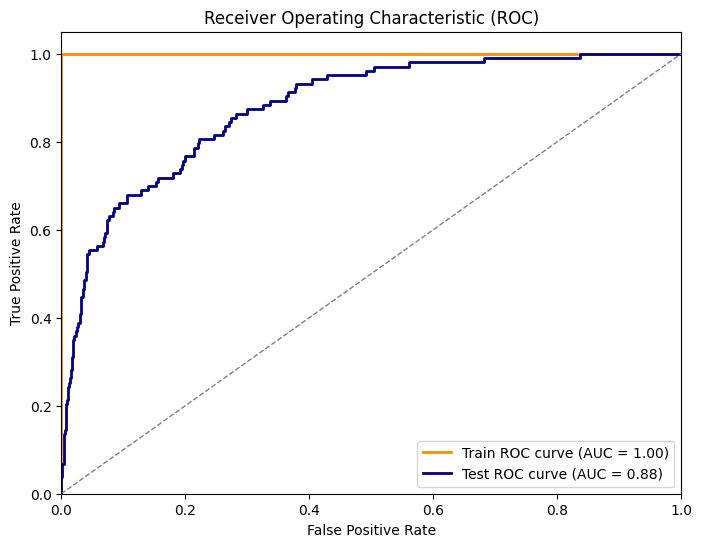

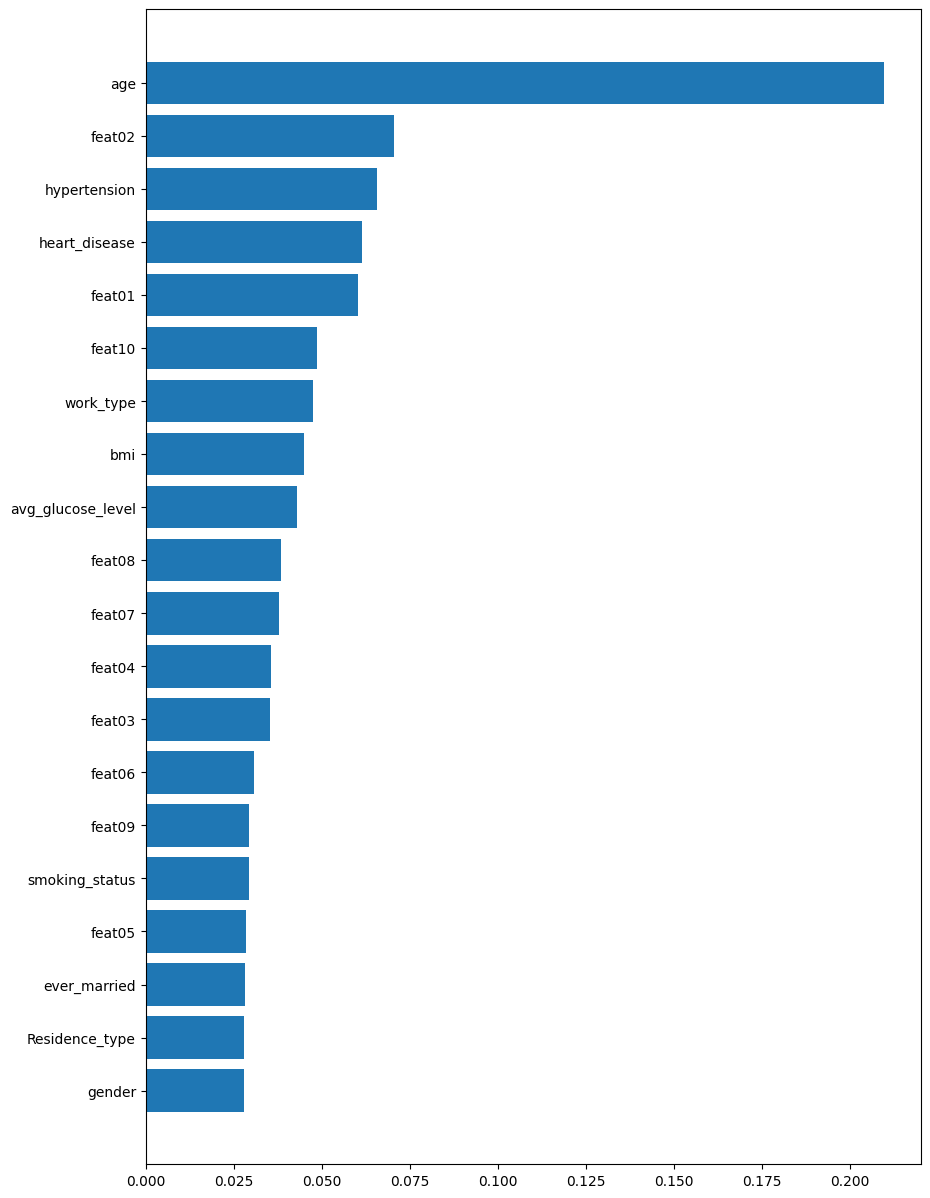

In [5]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()

Accuracy: 90.39%


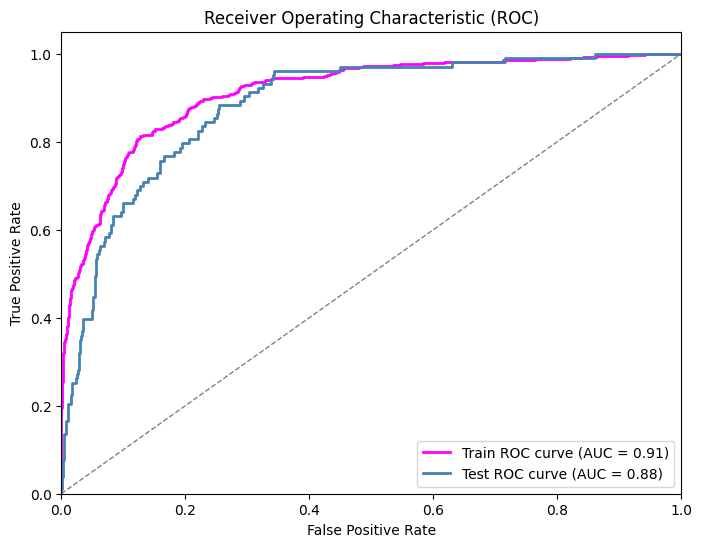

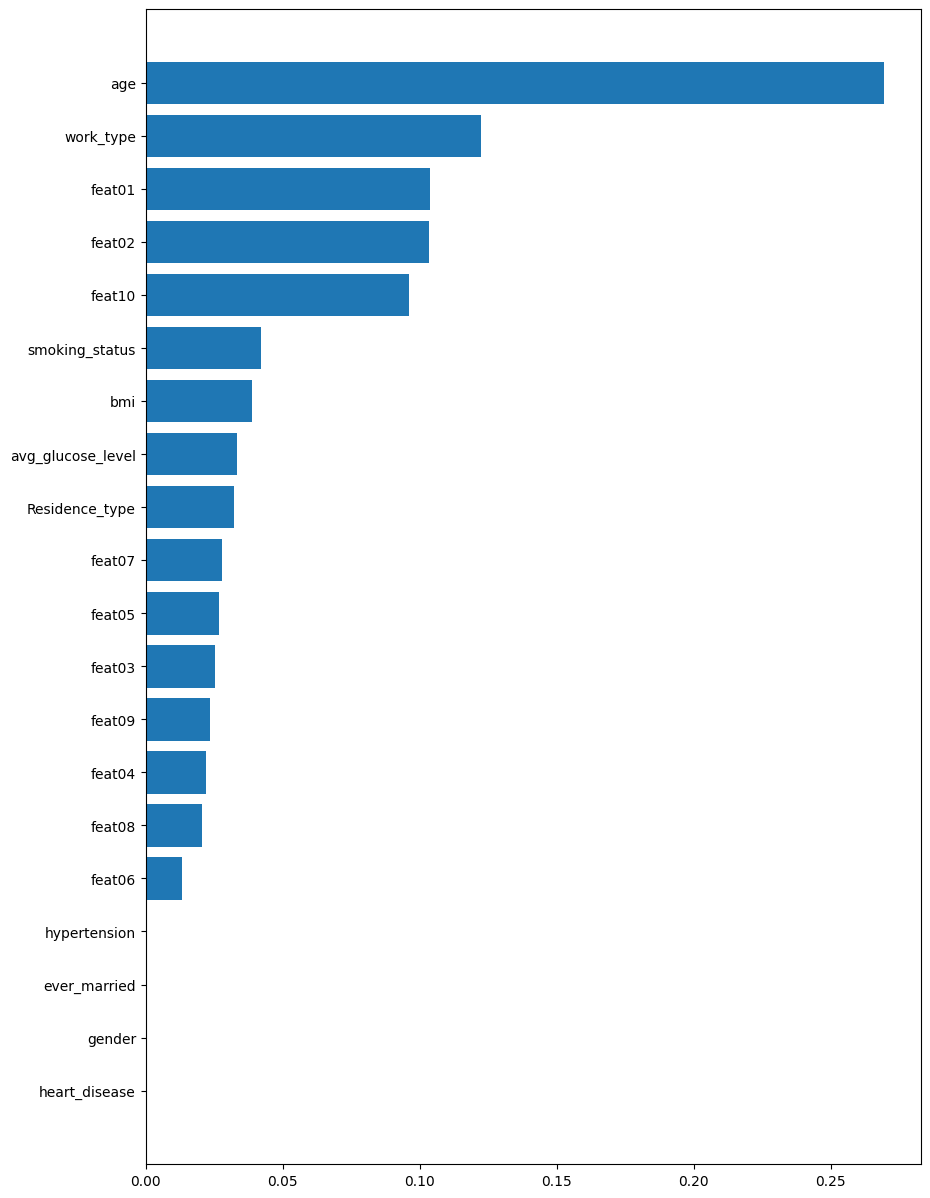

In [6]:
# fit model no training data
model = XGBClassifier(learning_rate = 0.3, n_estimators = 400, max_depth = 10, min_child_weight = 8, scale_pos_weight = 0.07)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='fuchsia', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='steelblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
# model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()

### Feature selection

In [15]:
# train_selected, drop_lst= toad.selection.select(frame = X_train,
#                                                 target=y_train,  
#                                                 iv = 0.03, corr = 0.6, 
#                                                 return_drop=True 
#                                                 )
# print("keep:",train_selected.shape[1],
#       "drop empty:",len(drop_lst['empty']),
#       "drop iv:",len(drop_lst['iv']),
#       "drop corr:",len(drop_lst['corr']))

# def output_iv_importance(train_selected,label_col):
#     feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
#     feat_import_iv=feat_import_iv['iv']
#     feat_import_iv = feat_import_iv.reset_index()
#     feat_import_iv.columns = ['name','iv']
#     return feat_import_iv
# df_iv=output_iv_importance(train_selected, y_train)
# df_iv = df_iv[df_iv['iv'] < 0.95]
# df_iv.shape


X = X[X.columns[sorted_idx][0:14]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# df_iv

NameError: name 'sorted_idx' is not defined

Accuracy: 90.76%


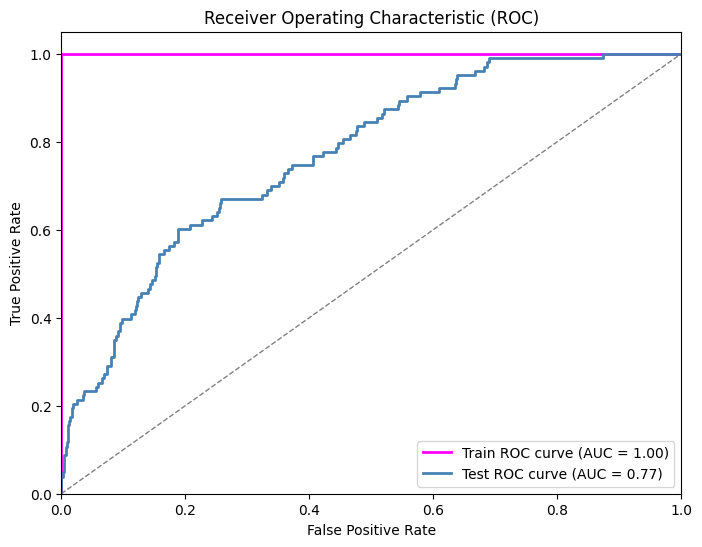

In [10]:
# fit model no training data
model = XGBClassifier()#learning_rate = 0.3, n_estimators = 400, max_depth = 10, min_child_weight = 8, scale_pos_weight = 0.07)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='fuchsia', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='steelblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

<BarContainer object of 14 artists>

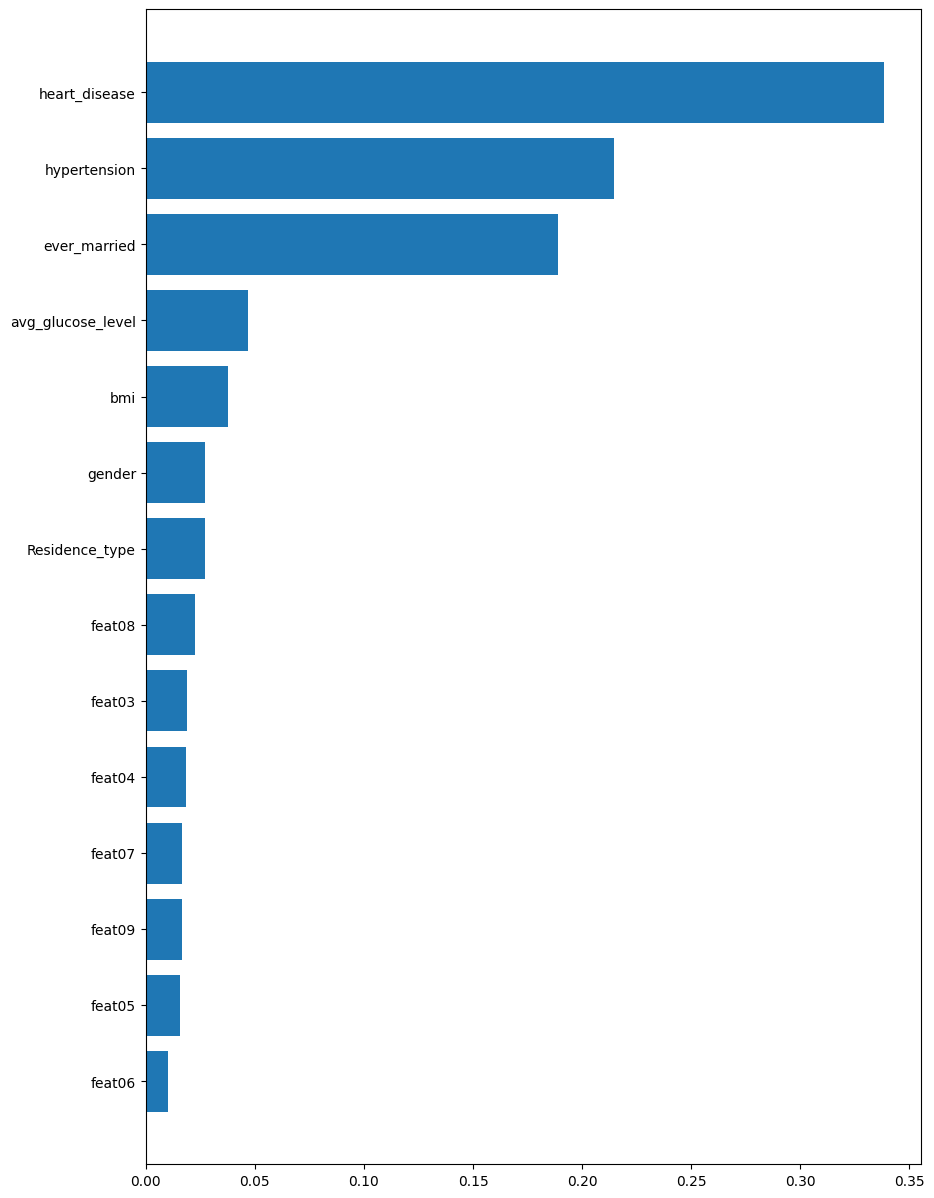

In [9]:
# model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])

In [23]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score

X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']


numerical_features = ['age', 'avg_glucose_level', 'bmi', 'feat01', 'feat02',
       'feat03', 'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat09',
       'feat10', 'heart_disease', 'hypertension']
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_features = [ 'Residence_type', 'smoking_status', 'work_type', 'ever_married']
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

classifier = MLPClassifier(random_state=0, max_iter = 500, learning_rate = 0.01, hidden_layer_sizes = (100, 100, 100))

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])

stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies_test = []
accuracies_train = []

for train_index, test_index in stratified_kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc_train = balanced_accuracy_score(y_train, clf.predict(X_train))
    acc_test = balanced_accuracy_score(y_test, y_pred)
    accuracies_test.append(acc_test)
    accuracies_train.append(acc_train)



# Calculate the mean AUC score from cross-validation
mean_accuracy_train = np.mean(accuracies_train)
mean_accuracy_test = np.mean(accuracies_test)


print('train:', accuracies_train, 'test:', accuracies_test)


c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

train: [1.0, 1.0, 1.0, 0.9987437185929648, 1.0] test: [0.671275966239995, 0.6503086419753086, 0.7172222222222222, 0.6640534979423869, 0.654040404040404]


c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the range of hyperparameters
param_dist = {
    'classifier__hidden_layer_sizes': [(50, ), (100, ), (150, ), (50, 50), (100, 100), (150, 150)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
    'classifier__max_iter': randint(200, 1000),  # Range from 200 to 1000
    'classifier__early_stopping': [True, False],
    'classifier__validation_fraction': [0.1, 0.2, 0.3]
}

# Create an MLPClassifier
classifier = MLPClassifier(random_state=0)

# Use the pipeline and include the classifier inside the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=50, cv=stratified_kf, scoring='balanced_accuracy', verbose=1, n_jobs=-1, random_state=42)

# Fit the random search to find the best hyperparameters
random_search.fit(X, y)

# Get the best hyperparameters
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Balanced Accuracy:", best_score)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'classifier__activation': 'relu', 'classifier__alpha': 0.01, 'classifier__early_stopping': False, 'classifier__hidden_layer_sizes': (150,), 'classifier__learning_rate': 'constant', 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 493, 'classifier__solver': 'sgd', 'classifier__validation_fraction': 0.1}
Best Balanced Accuracy: 0.6728957370899817
